# A4 - pyIBA and Tensorflow: Machine Learning demo

In [1]:
import sys
sys.path.insert(0, '/home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/test/')

from pyIBA import IDF
from pyIBA.codes.NDF import run_ndf, read_str_file

IDFViewer = sys.path[0] + 'NDF_gui.py'

sys.path.insert(1, '/home/msequeira/Dropbox/CTN/jupyter_notebooks/RBSpy/')
from RBSpy import rbsAux

from os import mkdir
from os.path import dirname

import numpy as np
import matplotlib.pyplot as plt

# %matplotlib notebook
%matplotlib inline

# Create the IDF file

In [2]:
save_path = '../Example_a4/original_file.xml'

In [3]:
idf_file = IDF(save_path)

## Define molecules

In [4]:
molecules = {'nelements': '3',
             0: {'name': 'Co 0.45 Pt 0.55',
              'density': '',
              'concentration': ['0', '5000'],
              'depth': ['0','1']},
             1: {'name': 'Si 1 O 2',
              'density': '',
              'concentration': ['0','5000'],
              'depth': ['0','1']},
             2: {'name': 'Si',
              'density': '',
              'concentration': ['100','10000000'],
              'depth':[ '0', '1']}}

idf_file.set_elements(molecules)

In [5]:
idf_file.get_elements()

{'nelements': 3,
 0: {'name': 'Co 0.45 Pt 0.55',
  'density': '',
  'concentration': ['0', '5000'],
  'depth': ['0', '1']},
 1: {'name': 'Si 1 O 2',
  'density': '',
  'concentration': ['0', '5000'],
  'depth': ['0', '1']},
 2: {'name': 'Si',
  'density': '',
  'concentration': ['100', '10000000'],
  'depth': ['0', '1']}}

## Define profile

In [6]:
profile = {'nlayers': '3',
         0: {'thickness': 1500, 'concentrations': [100.0, 0.0, 0.0]},
         1: {'thickness': 3000, 'concentrations': [0.0, 100.0, 0.0]},
         2: {'thickness': 5e6, 'concentrations': [0.0, 0.0, 100.0]},
         'names': ['Co 0.45 Pt 0.55', 'Si 1 O 2', 'Si']}

idf_file.set_profile(profile)

## Set NDF run options

In [7]:
# options = ['fitmethod','channelcompreesion','convolute','distribution','smooth','normalisation']

idf_file.set_NDF_run_option('channelcompreesion', '0 - No compression')
idf_file.set_NDF_run_option('convolute', '1 - Convolute FWHM')
idf_file.set_NDF_run_option('distribution', '0 - Don\'t use isotropic distribution')
idf_file.set_NDF_run_option('smooth', '1 - Smooth data')
idf_file.set_NDF_run_option('normalisation', '1 - Normalise profile')
idf_file.set_NDF_run_option('fitmethod', '0 - Simulate one spectrum from ndf.prf, no fit')

## Save file

In [8]:
idf_file.save_idf(save_path);

## Open the file in IDFVIewer to check and add missing data

In [10]:
!python3 $IDFViewer $save_path

Opening file...
Path: ../Example_a4/
File: original_file.xml


# Run NDF

In [ ]:
run_ndf(idf_file)

In [ ]:
idf_file.set_spectra_result(spectra_id = 0)
channel, counts = idf_file.get_dataxy_fit()

# create the figure
fig, ax = rbsAux.create_figure(
    xlim = [0, 1050], ylim=[-50, 4500], title = '', fig_size=[6, 4], depth_scale = False)

ax.plot(channel, counts)

fig.tight_layout()

## Run NDF simulations for multiple concentrations of Co$_x$Pt$_{1-x}$

In [14]:
def create_tree_folder(molecules):
    # organize new files with new folders and names
    path_dir = 'ML_data/' #idf_file.path_dir
    
    name_file = molecules[0]['name'].replace(' ', '_').replace('.','')
    new_dir = path_dir + name_file + '/'
    new_name = name_file + '.xml'      

    try: mkdir(new_dir)
    except: pass 
    
    return new_dir + new_name



concentrations = np.linspace(0, 1, 11)
list_idfs = []

for c in concentrations:
    molecules[0]['name'] = 'Co %0.2f Pt %0.2f'%(c, 1-c)
    profile['names'][0] = molecules[0]['name']
    
    idf_file.set_elements(molecules)
    idf_file.set_profile(profile)
    
    path_new_idf = create_tree_folder(molecules)
    
    
    idf_file.save_idf(path_new_idf)
    
    list_idfs.append(idf_file.copy()) 
    
for idf_new in list_idfs:
    print(idf_new.file_name)
    
#     print(molecules[0]['name'])

Co_000_Pt_100.xml
Co_010_Pt_090.xml
Co_020_Pt_080.xml
Co_030_Pt_070.xml
Co_040_Pt_060.xml
Co_050_Pt_050.xml
Co_060_Pt_040.xml
Co_070_Pt_030.xml
Co_080_Pt_020.xml
Co_090_Pt_010.xml
Co_100_Pt_000.xml


In [ ]:
for idf in list_idfs:
    run_ndf(idf)

In [ ]:
idf_file = IDF(save_path)

In [ ]:
idf_file.append_simulation_entry(len(list_idfs))

fig, ax = rbsAux.create_figure(
    xlim = [0, 1050], ylim=[-50, 6500], title = '', fig_size=[6, 4], depth_scale = False)

for i,idf in enumerate(list_idfs):
    idf.set_spectra_result()
    idf.set_elements_result()
    channel, counts = idf.get_dataxy_fit()
    
    idf_file.set_spectrum_data_fit_result(channel, counts, simulation_id=i)
    
    ax.plot(channel, counts, label = idf.file_name)

ax.legend(frameon = False)
fig.tight_layout()

In [20]:
idf_file.save_idf(save_path)

# Machine Learning

In [11]:
#load modules
from tensorflow import keras
from tensorflow.keras import layers
import datetime

#this part of the code is only needed to reset the learning session on the Jupyter Kernel.
import tensorflow as tf


tf.keras.backend.clear_session()

## Define Neural Network

In [15]:
## NN deffinition
#del model
num_neurons = 32
input_len = len(list_idfs[0].get_dataxy_fit()[0])
output_len = 1

activation='tanh'

model = keras.Sequential()
# Add layers:
model.add(layers.GaussianNoise(0.0001, input_shape=(input_len,)))
model.add(layers.Dense(45,input_dim=input_len, activation=activation))
# model.add(layers.Dense(2, activation=activation))
model.add(layers.Dense(num_neurons, activation=activation))
model.add(layers.Dense(num_neurons, activation=activation))
model.add(layers.Dense(output_len, activation='relu'))

# Compile
model.compile(optimizer=keras.optimizers.Adam(0.0003),
              loss='mse',
              metrics=['mse'])

## Organize inputs/outputs

In [16]:
inputs_real = []
for idf in list_idfs:
    channel, counts = idf.get_dataxy_fit()
    
    inputs_real.append(counts)
    
inputs_real = np.array(inputs_real)
outputs_real = np.array(concentrations)

print(inputs_real.shape)
print(outputs_real.shape)

(11, 1023)
(11,)


### Create more spectra by adding random noise

In [17]:
samples_to_add = 5

inputs = []
outputs = []

for inp, outp in zip(inputs_real, outputs_real):
    for _ in range(samples_to_add):
        input_noise = inp + np.random.normal(0, 25, size=input_len)
        inputs.append(input_noise)
        
        outputs.append(outp)
        
inputs = np.array(inputs)
outputs= np.array(outputs)
        
    
#randomize inputs and outputs
index_random = np.random.permutation(len(outputs))
inputs = inputs[index_random,:]
outputs = outputs[index_random]

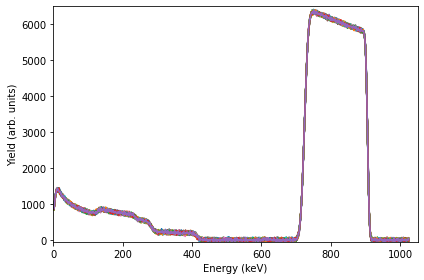

In [18]:
fig, ax = rbsAux.create_figure(
    xlim = [0, 1050], ylim=[-50, 6500], title = '', fig_size=[6, 4], depth_scale = False)

for inp, outp in zip(inputs, outputs):
    ax.plot(channel, inp)
    
fig.tight_layout()

## Train the network

In [19]:
%%time

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.load_weights('ML_data/final_model_state')
# hist = model.fit(inputs, outputs, epochs=600, batch_size=11, callbacks=[tensorboard_callback])

CPU times: user 101 ms, sys: 1.67 ms, total: 103 ms
Wall time: 124 ms


In [24]:
try:
    plt.figure(figsize=(6,4))
    plt.plot(hist.history['mse'])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    model.summary()
except:
    pass

<Figure size 432x288 with 0 Axes>

## Verify the training

In [21]:
idf_file = IDF(save_path)
concentrations_compare = [0.15, 0.65, 0.43, 0.81, 0.94]
list_idfs_compare = []

for c in concentrations_compare:
    molecules[0]['name'] = 'Co %0.2f Pt %0.2f'%(c, 1-c)
    profile['names'][0] = molecules[0]['name']
    
    idf_file.set_elements(molecules)
    idf_file.set_profile(profile)
    
    path_new_idf = create_tree_folder(molecules)
    
    
    idf_file.save_idf(path_new_idf)
    list_idfs_compare.append(idf_file.copy())
    
for idf in list_idfs_compare:
    run_ndf(idf)
    
    

Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/test/pyIBA/codes/NDF_11_MS/NDF.exe Co_015_Pt_085.xml 0 0 1 0 1 1
Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/test/pyIBA/codes/NDF_11_MS/NDF.exe Co_065_Pt_035.xml 0 0 1 0 1 1
Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/test/pyIBA/codes/NDF_11_MS/NDF.exe Co_043_Pt_057.xml 0 0 1 0 1 1
Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/test/pyIBA/codes/NDF_11_MS/NDF.exe Co_081_Pt_019.xml 0 0 1 0 1 1
Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/test/pyIBA/codes/NDF_11_MS/NDF.exe Co_094_Pt_006.xml 0 0 1 0 1 1


In [22]:
for idf in list_idfs_compare:
    idf.set_spectra_result()


True --> Predicted


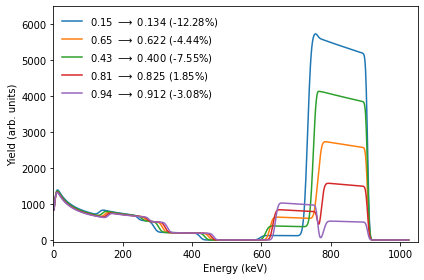

In [23]:
print('True --> Predicted')

fig, ax = rbsAux.create_figure(
    xlim = [0, 1050], ylim=[-50, 6500], title = '', fig_size=[6, 4], depth_scale = False)

for idf, conc in zip(list_idfs_compare, concentrations_compare):
    channel, data = idf.get_dataxy_fit()
    prediction = model.predict(np.array([data]))
    
    label = r'%0.2f $\longrightarrow$ %0.3f (%0.2f%%)' %(conc, prediction[0][0], 100 - conc/prediction[0][0]*100)
    plt.plot(channel, data, label = label)

ax.legend(frameon=False)
fig.tight_layout()

## Save model training weights

In [39]:
# model.save_weights('ML_data/final_model_state')